## Network Coding Demo

Author: Cheuk Ting Li  

In [1]:
from psitip import *
PsiOpts.setting(
    solver = "ortools.GLOP",    # Set linear programming solver
    repr_latex = True,          # Jupyter Notebook LaTeX display
    venn_latex = True,          # LaTeX in diagrams
    proof_note_color = "blue",  # Reasons in proofs are blue
    random_seed = 4321          # Random seed for example searching
)

------
## Butterfly Network

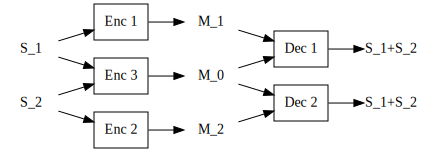

In [2]:
S1, S2 = rv_array("S", 1, 3)
M0, M1, M2 = rv_array("M", 3)
R1, R2 = real_array("R", 1, 3)
C0, C1, C2 = real_array("C", 3)

model = CodingModel()      # Butterfly network [Ahlswede-Cai-Li-Yeung 2000]
model.set_rate(S1, R1)     # The rates of S1,S2 are R1,R2 resp.
model.set_rate(S2, R2)
model.set_rate(M0, C0)     # The rates of M0,M1,M2 are C0,C1,C2 resp.
model.set_rate(M1, C1)
model.set_rate(M2, C2)
model.add_node(S1, M1,
        label = "Enc 1")   # Encoder 1 maps S1 to M1
model.add_node(S2, M2,
        label = "Enc 2")   # Encoder 2 maps S2 to M2
model.add_node(S1+S2, M0,
        label = "Enc 3")   # Encoder 3 maps S1,S2 to M0
model.add_node(M0+M1, S1+S2,
        label = "Dec 1")   # Decoder 1 maps M0,M1 to S1,S2
model.add_node(M0+M2, S1+S2,
        label = "Dec 2")   # Decoder 2 maps M0,M2 to S1,S2

model.graph()              # Draw diagram

In [3]:
r = model.get_inner()  # Automatic inner bound
r

( ( C_1 >= 0 )
 &( C_2 >= 0 )
 &( R_1 >= 0 )
 &( R_2 >= 0 )
 &( R_1 <= C_0 )
 &( R_2 <= C_0 )
 &( R_1+R_2 <= C_0+C_1 )
 &( R_1+R_2 <= C_0+C_2 ) )

------
## Vámos Network

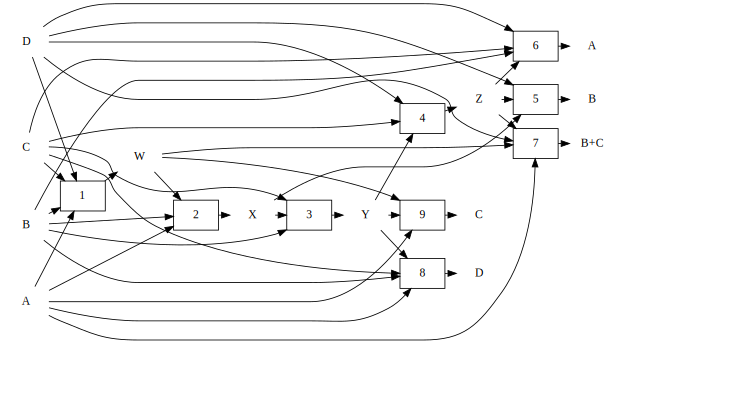

In [4]:
A, B, C, D = rv("A, B, C, D")
W, X, Y, Z = rv("W, X, Y, Z")
R = real("R")

# Define Vámos network [Dougherty-Freiling-Zeger 2007]
model = CodingModel()
for S in A+B+C+D:
    model.set_rate(S, R)
for M in W+X+Y+Z:
    model.set_rate(M, 1)

model.add_node(A+B+C+D, W)
model.add_node(A+B+W, X)
model.add_node(B+C+X, Y)
model.add_node(C+D+Y, Z)

model.add_node(D+X+Z, B)
model.add_node(B+C+D+Z, A)
model.add_node(A+D+W+Z, B+C)
model.add_node(A+B+C+Y, D)
model.add_node(A+W+Y, C)

model.graph(nodesep = 0.15, ranksep = 0.2, resolution = 60)  # Draw diagram

In [5]:
# Automatic inner bound, use skip_simplify for speedup
r = model.get_inner(skip_simplify = True)
r

( ( R >= 0 )
 &( I(W&A+B+C+D) <= 1 )
 &( I(X&A+B+W) <= 1 )
 &( I(Y&B+C+X) <= 1 )
 &( I(Z&C+D+Y) <= 1 )
 &( R <= I(B&D+X+Z) )
 &( R <= I(A&B+C+D+Z) )
 &( R <= I(B&A+D+W+Z) )
 &( R <= I(C&A+D+W+Z) )
 &( R <= I(D&A+B+C+Y) )
 &( R <= I(C&A+W+Y) )
 &( indep(B, A, C, D) )
 &( markov(C+D, B+A+W, X) )
 &( markov(A+D+W, B+C+X, Y) )
 &( markov(B+A+W+X, C+D+Y, Z) ) ).exists(A+B+C+D+W+X+Y+Z)

In [6]:
# Bound the capacity (maximum of R) under the contraints r
# By default, only Shannon-type inequalities are considered,
# so the program can only find the upper bound 1
r.discover(R).maximum(R, R)

1

In [7]:
# Output proof
(r >> (R <= 1)).proof()

In [8]:
# Find a better bound via Zhang-Yeung inequality [Zhang-Yeung 1998]

# Region of Zhang-Yeung inequality applied on combinations of A,B,C,D
zy = universe().incorporated(A+B+C+D, zydfz_thm("zy"))

# According to [Dougherty-Freiling-Zeger 2007, Thm VI.2], we apply 
# Zhang-Yeung inequality on (A,W), (B,X), (C,Y), (D,Z)
zy.substitute({A: A+W, B: B+X, C: C+Y, D: D+Z})

# Bound the capacity using Zhang-Yeung inequality,
# gives [Dougherty-Freiling-Zeger 2007, Thm VI.2]
(r.noaux() & zy).discover(R).maximum(R, R)

10/11

In [9]:
# Output proof
((r.noaux() & zy) >> (R <= 10/11)).proof()

In [10]:
# Find a bound on the linear coding capacity

# Ingleton bound [Ingleton 1971] is valid for linear code
ing = ingleton_bound(A, B, C, D)

# According to [Dougherty-Freiling-Zeger 2007, Thm VI.8], we apply 
# Ingleton bound on (A,W), (B,X), (C,Y), (D,Z)
ing.substitute({A: A+W, B: B+X, C: C+Y, D: D+Z})

# Bound the linear coding capacity using Ingleton bound,
# gives [Dougherty-Freiling-Zeger 2007, Thm VI.8]
(r.noaux() & ing).discover(R).maximum(R, R)

5/6

In [11]:
# Output proof
((r.noaux() & ing) >> (R <= 5/6)).proof()

### References
-  R. Ahlswede, N. Cai, S.-Y. R. Li, and R. W. Yeung, "Network Information Flow," IEEE Transactions on Information Theory, vol. 46, no. 4, pp. 1204-1216, Jul. 2000.
- S.-Y. R. Li, R. W. Yeung, and N. Cai, "Linear Network Coding," IEEE Transactions on Information Theory, vol. 49, no. 2, pp. 371-381, Jul. 2003.
- R. Dougherty, C. Freiling, and K. Zeger, "Networks, matroids, and non-Shannon information inequalities," IEEE Transactions on Information Theory, vol. 53, no. 6, pp. 1949-1969, 2007.
- Z. Zhang and R. W. Yeung, "On characterization of entropy function via information inequalities," IEEE Trans. Inform. Theory, vol. 44, pp. 1440-1452, Jul 1998.
- A. W. Ingleton, "Representation of matroids," in Combinatorial mathematics and its applications, D. Welsh, Ed. London: Academic Press, pp. 149–167, 1971.